In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
#from collections import Counter
!pip install ucimlrepo

# %% [markdown]
# DATA INGESTION in pipeline

# %%
#Dataset
from ucimlrepo import fetch_ucirepo
cancer_data = fetch_ucirepo(id=17) # fetch dataset
# data (as pandas dataframes)
X = cancer_data.data.features
y = cancer_data.data.targets
ids= cancer_data.data.ids


Features shape: (569, 30)
Target shape: (569, 1)
IDs shape: (569, 1)
   radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0    17.99     10.38      122.80  1001.0      0.11840       0.27760   
1    20.57     17.77      132.90  1326.0      0.08474       0.07864   
2    19.69     21.25      130.00  1203.0      0.10960       0.15990   
3    11.42     20.38       77.58   386.1      0.14250       0.28390   
4    20.29     14.34      135.10  1297.0      0.10030       0.13280   

   concavity1  concave_points1  symmetry1  fractal_dimension1  ...  radius3  \
0      0.3001          0.14710     0.2419             0.07871  ...    25.38   
1      0.0869          0.07017     0.1812             0.05667  ...    24.99   
2      0.1974          0.12790     0.2069             0.05999  ...    23.57   
3      0.2414          0.10520     0.2597             0.09744  ...    14.91   
4      0.1980          0.10430     0.1809             0.05883  ...    22.54   

   texture3  perimeter3   are

In [ ]:
# Check the shape of data
print(f"Features shape: {X.shape}") #Features shape:  (569, 30)
print(f"Target shape: {y.shape}") #Target shape: (569, 1)
print(f"IDs shape: {ids.shape}") #IDs shape: (569, 1)
# Look at data
print(X.head())

# %%
print(y.head())
print(ids.head())
print (y.value_counts()) # Check target distribution: 357 benign (2), 212 malignant (4)
print(X.isnull().sum())# Check for missing values
print("ID CHECK")
print(ids.isnull().sum())# Check for missing values in ids column

# %%
# Basic statistics
print("DATA STATS")
print(X.info()) #all float
print(X.describe()) # count, mean, std, min, 25%, 50%, 75%, max for each feature

# %%
print(y.describe()) #569

# %% [markdown]
# Data Cleaning - Handle missing values in 'Bare_nuclei' column

# %%
print((X.isnull().sum()/ len(X))) #no empty values
duplicate_check=X.duplicated().any() # Check for duplicate rows
print(f"Are there duplicate rows? {duplicate_check}")

# %% [markdown]
# keep outliers

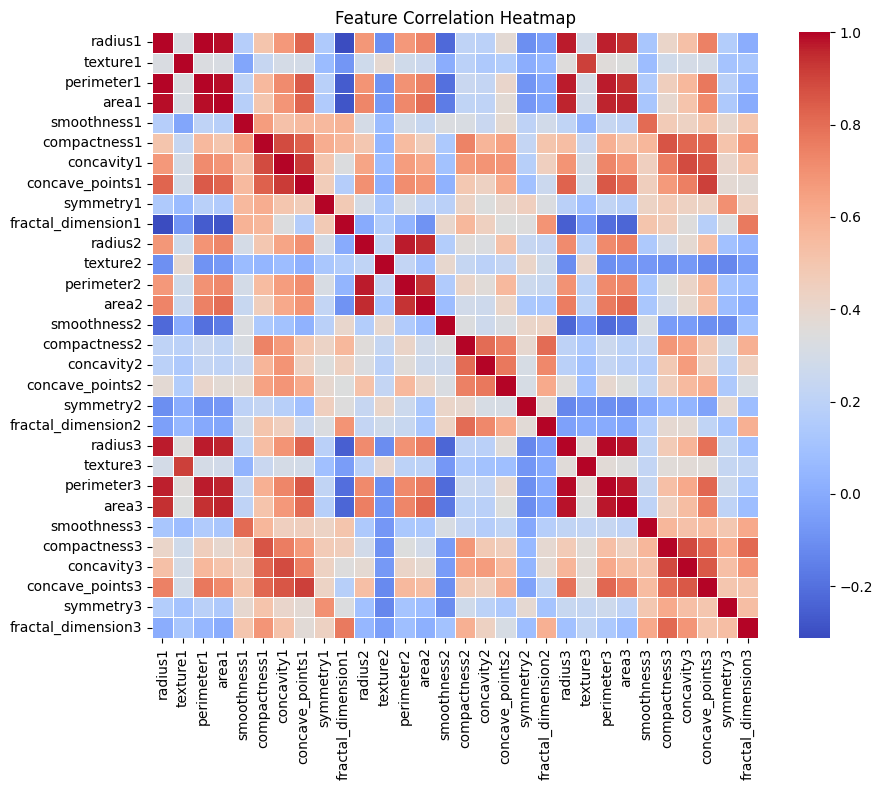

In [ ]:
# Correlation matrix to see relationships between features
plt.figure(figsize=(10,8))
correlation_matrix = X.corr() #correlation matrix
#print(correlation_matrix)
sns.heatmap(correlation_matrix, fmt=".2f", cmap='coolwarm', square=True, linecolor='white', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
corr_heatmap=plt.show()
corr_heatmap.savefig('correlation_heatmap.png')


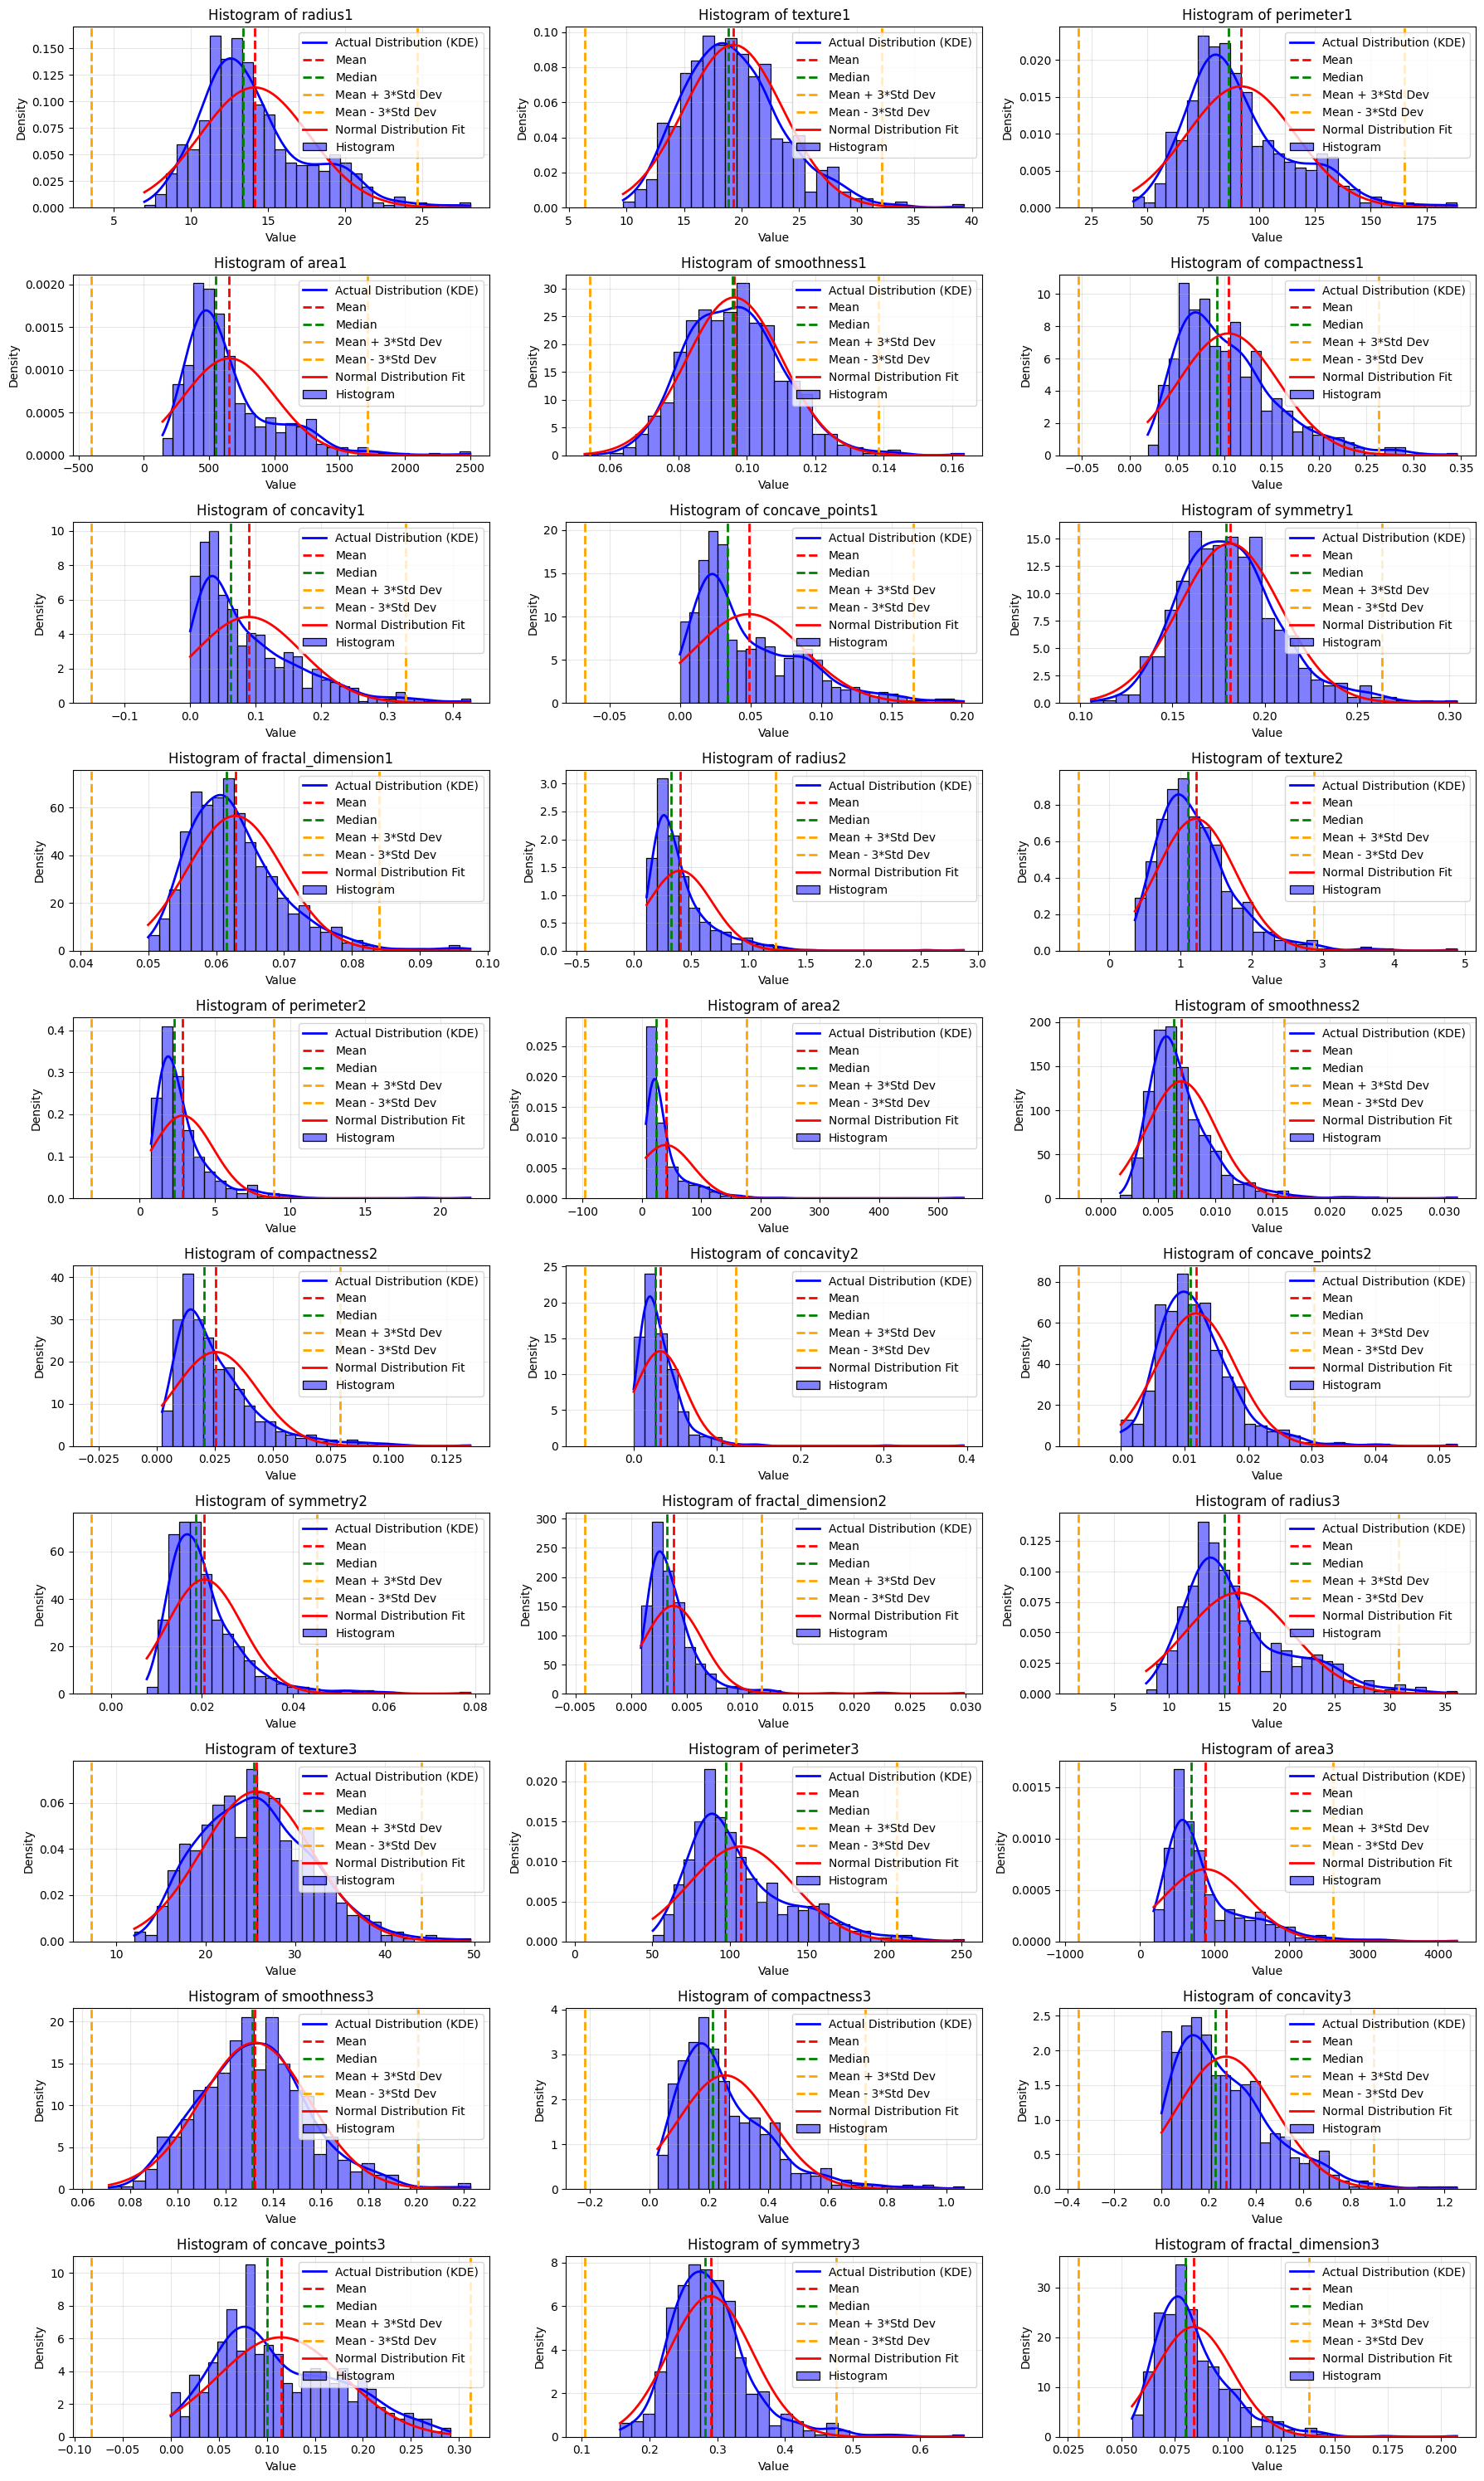

In [3]:
#Histogram for all features to find outliers
fig, axes= plt.subplots(10,3, figsize=(18,30))
axes= axes. flatten()

for i, column in enumerate(X.columns):
    ax=axes[i]
    mean = X[column].mean()
    std = X[column].std()
    median= X[column].median()
    x= np.linspace(X[column].min(), X[column].max(), 100)

    sns.histplot(X[column], bins=30, kde=True, color='blue', edgecolor='black', ax=ax, stat= 'density', label='Histogram', line_kws={'color': 'purple', 'lw': 2, 'label': 'Actual Distribution (KDE)'})
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=2, label='Mean')
    ax.axvline(median, color='green', linestyle='dashed', linewidth=2, label='Median')
    ax.axvline(mean + 3*std, color='orange', linestyle='dashed', linewidth=2, label='Mean + 3*Std Dev')
    ax.axvline(mean - 3*std, color='orange', linestyle='dashed', linewidth=2, label='Mean - 3*Std Dev')

    normal_curve= stats.norm.pdf(x, mean, std)
    ax.plot(x, normal_curve, color='red', linewidth=2, label='Normal Distribution Fit')
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Diagnosis
B            62.741652
M            37.258348
Name: proportion, dtype: float64


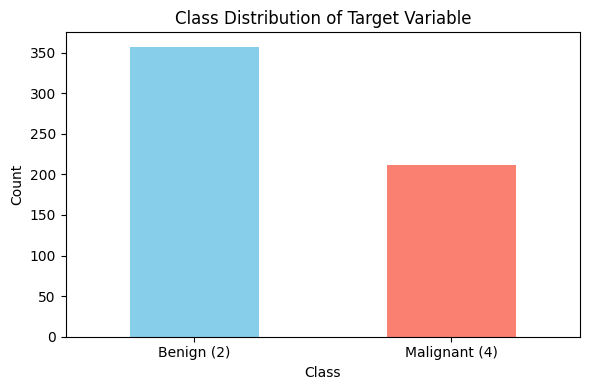

In [4]:
# %%
# Class Distribution
print(y.value_counts(normalize=True)*100) # Class distribution percentages: B- 62.742%, M 37.258%
plt.figure(figsize=(6,4))
y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution of Target Variable')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0,1], labels=['Benign (2)', 'Malignant (4)'], rotation=0)
plt.tight_layout()
plt.show()



In [ ]:

feature_list=['radius','texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension']
fig, axes= plt.subplots(5,2, figsize=(12,12))
axes= axes.flatten()

for i, feature in enumerate(feature_list):
  col_plot=[f'{feature}1', f'{feature}2', f'{feature}3']
  X[col_plot].boxplot(ax=axes[i])
  axes[i].set_title(f'{feature.capitalize()}- All 3 measurements', fontsize=12)
  axes[i].set_ylabel('Value')
  axes[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [ ]:
# %%
# Regression= scatter plot
feature_list=['radius','texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension']
fig, axes= plt.subplots(10,3, figsize=(15,25))
#axes=axes.flatten()

for i, feature in enumerate(feature_list):
    for j in range(1,4):
        column=f'{feature}{j}'
        axes[i, j-1].scatter(range(len(X)), X[column], alpha=0.5)

        if i==9:
            axes[i, j-1].set_xlabel('Index')
        if j==1:
            axes[i, j-1].set_ylabel(f'{feature}')

        axes[i, j-1].set_title(f'Scatter Plot of {column} -Outlier Detection')

plt.tight_layout()
plt.show() #out of loop to see all graphs together


In [ ]:

# ENCODING
y_encoded= y.replace({2:0, 4:1}) # Encode target variable: 2 -> 0 (benign), 4 -> 1 (malignant)
#y_singleCol= y_encoded.values.ravel()) # Check encoded target values
print("Unique values",y_encoded.nunique()) # Check unique values in encoded target: [0, 1]
print("Value count",y_encoded.value_counts()) # Check encoded target distribution: 0- 357, 1- 212
print("Percentages",y_encoded.value_counts(normalize=True)*100) # Percentages: 0- 62.741652%, 1- 37.258348%


# SCALING
train_mean= X_train.mean()
train_std= X_train.std()
print("Train mean", train_mean)
print("Train std", train_std)

X_train_scaled= (X_train - train_mean)/ train_std
X_test_scaled= (X_test - train_mean)/ train_std # standarised using train mean and std


# %%
# Convert scaled pandas DataFrames to NumPy arrays
X_train_np = X_train_scaled.values
X_test_np  = X_test_scaled.values

y_train_np = y_train.values.ravel()
y_test_np  = y_test.values.ravel()


# %%
print("Scaled training set", X_train_scaled.mean())
print("Scaled testing set", X_test_scaled.mean())
print("Scaled training set std", X_train_scaled.std())  #all std=1
print("Scaled testing set std", X_test_scaled.std())  #close to 1
print("Shape", X_train_scaled.shape, X_test_scaled.shape)

In [ ]:
# %% [markdown]
# TRAIN-TEST SPLIT

# %% [markdown]
# References:
# https://www.datacamp.com/tutorial/decision-tree-classification-python
# https://medium.com/@enozeren/building-a-decision-tree-from-scratch-324b9a5ed836 from pg194

# %%
#Plan:class separation, shuffle in each class, split into class, merge, shuffle merged
np.random.seed(42)

# Separate classes
benign_indices = y_encoded[y_encoded == 0].index.tolist()
malignant_indices = y_encoded[y_encoded == 1].index.tolist()

# Shuffle indices within each class
np.random.shuffle(benign_indices)
np.random.shuffle(malignant_indices)

# Split indices into train and test sets (80-20 split)
test_size=0.2 #80/20 but could try 70/30
benign_split = int(len(benign_indices)*(1 - test_size))
print("Number of indices benign", benign_split)
malignant_split = int(len(malignant_indices)*(1 - test_size))
print("Number of malignant", malignant_split)

benign_train_indices = benign_indices[:benign_split] #80% for training
benign_test_indices = benign_indices[benign_split:] #20% for testing

malignant_train_indices = malignant_indices[:malignant_split]
malignant_test_indices = malignant_indices[malignant_split:]


#Merge train and test indices
train_set= benign_train_indices + malignant_train_indices
test_set= benign_test_indices + malignant_test_indices

# Shuffle merged train and test sets
np.random.shuffle(train_set)
np.random.shuffle(test_set)

X_train= X.loc[train_set]
y_train= y_encoded.loc[train_set]
X_test= X.loc[test_set]
y_test= y_encoded.loc[test_set]
print("Train shape:", X_train.shape, y_train.shape) #(910, 30) (910, 1), should be 80% of 569=484
print("Test shape:", X_test.shape, y_test.shape) #(228, 30) (228, 1), should be 20% of 569=114

# %%
#CODE CHECK
print("X set", X_train.shape, X_test.shape)
print("Y set", y_train.shape, y_test.shape)
print("Training distribution",y_train.value_counts(), y_train.value_counts(normalize=True)*100)
print("Testing distribution",y_test.value_counts(), y_test.value_counts(normalize=True)*100)


# %%